In [3]:
from typing import Union, List

import torch
from torch import nn, Size

class CustomLayerNorm(nn.Module):
    def __init__(self, normalized_shape: Union[int, List[int], Size], *,
                 eps: float = 1e-5,
                 elementwise_affine: bool = True):
        
        super().__init__()
        
        if isinstance(normalized_shape, int):
            normalized_shape = torch.Size([normalized_shape])
        elif isinstance(normalized_shape, list):
            normalized_shape = torch.Size(normalized_shape)
        assert isinstance(normalized_shape, torch.Size)
        
        self.normalized_shape = normalized_shape
        self.eps = eps
        self.elementwise_affine = elementwise_affine
        
        if self.elementwise_affine:
            self.gain = nn.Parameter(torch.ones(normalized_shape))
            self.bias = nn.Parameter(torch.zeros(normalized_shape))
    
    def forward(self, x: torch.Tensor):
        assert self.normalized_shape == x.shape[-len(self.normalized_shape):]
        
        dims = [-(i + 1) for i in range(len(self.normalized_shape))]
        
        mean = x.mean(dim=dims, keepdim=True)
        
        var = ((x - mean) ** 2).mean(dim=dims, keepdim=True)
        
        x_norm = (x - mean) / torch.sqrt(var + self.eps)
        
        if self.elementwise_affine:
            x_norm = self.gain * x_norm + self.bias
        
        return x_norm


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import LayerNorm
import math

class SelfAttention(nn.Module):
    def __init__(self, emb_size, heads, dropout=0.1):
        super().__init__()
        self.heads = heads
        self.head_size = emb_size // heads
        self.scale = self.head_size ** -0.5
        
        self.use_flash = hasattr(F, 'scaled_dot_product_attention')
        
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.out = nn.Linear(emb_size, emb_size)
        self.attn_dropout = nn.Dropout(dropout)
        self.resid_dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.size()
        qkv = self.qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: t.view(B, T, self.heads, C // self.heads).transpose(1, 2), qkv)

        if self.use_flash:
            context = F.scaled_dot_product_attention(
                q, k, v, 
                attn_mask=None, 
                dropout_p=self.attn_dropout.p if self.training else 0.0
            )
        else:
            att = (q @ k.transpose(-2, -1)) * self.scale
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            context = att @ v
            
        context = context.transpose(1, 2).contiguous().view(B, T, C)
        out = self.resid_dropout(self.out(context))
        return out

class GELU(nn.Module):
    def forward(self, x):
        return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3.0))))

class TransformerBlock(nn.Module):
    def __init__(self, emb_size, heads, dropout=0.1):
        super().__init__()
        self.attn = SelfAttention(emb_size, heads, dropout)
        self.norm1 = LayerNorm(emb_size)
        self.ff = nn.Sequential(
            nn.Linear(emb_size, 4 * emb_size),
            GELU(),  
            nn.Dropout(dropout),
            nn.Linear(4 * emb_size, emb_size),
            nn.Dropout(dropout),
        )
        self.norm2 = LayerNorm(emb_size)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.ff(self.norm2(x))
        return x

class CustomTransformerBlock(nn.Module):
    def __init__(self, emb_size, heads, dropout=0.1):
        super().__init__()
        self.attn = SelfAttention(emb_size, heads, dropout)
        self.norm1 = CustomLayerNorm(emb_size)
        self.ff = nn.Sequential(
            nn.Linear(emb_size, 4 * emb_size),
            GELU(),  
            nn.Dropout(dropout),
            nn.Linear(4 * emb_size, emb_size),
            nn.Dropout(dropout),
        )
        self.norm2 = LayerNorm(emb_size)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.ff(self.norm2(x))
        return x


In [5]:
class MiniGPT(nn.Module):
    def __init__(self, vocab_size, emb_size=384, n_heads=6, n_layers=6, block_size=128, dropout=0.1):
        super().__init__()
        self.block_size = block_size
        
        self.token_embedding = nn.Embedding(vocab_size, emb_size)
        self.pos_embedding = nn.Parameter(torch.zeros(1, block_size, emb_size))
        self.emb_dropout = nn.Dropout(dropout)
        
        self.blocks = nn.Sequential(*[
            TransformerBlock(emb_size, n_heads, dropout) 
            for _ in range(n_layers)
        ])
        self.ln_f = nn.LayerNorm(emb_size)
        self.head = nn.Linear(emb_size, vocab_size)
        
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, x):
        B, T = x.shape
        assert T <= self.block_size, f"Input sequence length {T} exceeds model's context length {self.block_size}"
        
        tok = self.token_embedding(x)
        pos = self.pos_embedding[:, :T, :]
        x = self.emb_dropout(tok + pos)
        
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.head(x)
        
        return logits

    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.size(1) <= self.block_size else idx[:, -self.block_size:]
            logits = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
            
        return idx

class CustomMiniGPT(MiniGPT):
    def __init__(self, vocab_size, emb_size=384, n_heads=6, n_layers=6, block_size=128, dropout=0.1):
        super().__init__(vocab_size, emb_size, n_heads, n_layers, block_size, dropout)
        
        self.blocks = nn.Sequential(*[
            CustomTransformerBlock(emb_size, n_heads, dropout) 
            for _ in range(n_layers)
        ])
        self.ln_f = CustomLayerNorm(emb_size)

In [6]:
def load_shakespeare():
    text = open('tiny-shakesphere.txt', 'r').read()
    return text

text = load_shakespeare()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

print(f"Vocabulary size: {vocab_size}")

data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

block_size = 128
batch_size = 32

def get_batch(split):
    data_source = train_data if split == 'train' else val_data
    ix = torch.randint(0, len(data_source) - block_size - 1, (batch_size,))
    x = torch.stack([data_source[i:i+block_size] for i in ix])
    y = torch.stack([data_source[i+1:i+1+block_size] for i in ix])
    return x.to(device), y.to(device)

Using device: cuda
Vocabulary size: 65


In [7]:
@torch.no_grad()
def evaluate_model(model):
    model.eval()
    val_losses = []
    for _ in range(10):
        x, y = get_batch('val')
        logits = model(x)
        loss = F.cross_entropy(logits.view(-1, vocab_size), y.view(-1))
        val_losses.append(loss.item())
    
    model.train()
    return sum(val_losses) / len(val_losses)

In [8]:
import time
from tqdm import tqdm
def train_model(model, optimizer, max_steps=1000):
    model.train()
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, 
        T_max=max_steps,
        eta_min=1e-5
    )
    
    train_losses = []
    val_losses = []
    val_steps = []
    
    best_val_loss = float('inf')
    best_model_state = None
    
    t0 = time.time()
    
    progress_bar = tqdm(range(max_steps))
    for step in progress_bar:
        x, y = get_batch('train')
        
        logits = model(x)
        loss = F.cross_entropy(logits.view(-1, vocab_size), y.view(-1))
        train_losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        if step % 100 == 0 or step == max_steps - 1:
            val_loss = evaluate_model(model)
            val_losses.append(val_loss)
            val_steps.append(step)
            
            progress_bar.set_description(f"Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
    
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        model = model.to(device)
    
    total_time = time.time() - t0
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_steps': val_steps,
        'total_time': total_time,
        'best_val_loss': best_val_loss
    }

In [9]:

emb_size = 384
n_heads = 6
n_layers = 4  
max_steps = 1000
lr = 3e-4
weight_decay = 0.01

torch_model = MiniGPT(
    vocab_size=vocab_size, 
    emb_size=emb_size,
    n_heads=n_heads, 
    n_layers=n_layers,
    block_size=block_size
).to(device)

custom_model = CustomMiniGPT(
    vocab_size=vocab_size, 
    emb_size=emb_size,
    n_heads=n_heads, 
    n_layers=n_layers,
    block_size=block_size
).to(device)

torch_optimizer = torch.optim.AdamW(torch_model.parameters(), lr=lr, weight_decay=weight_decay)
custom_optimizer = torch.optim.AdamW(custom_model.parameters(), lr=lr, weight_decay=weight_decay)

print("Training model with PyTorch LayerNorm...")
torch_metrics = train_model(torch_model, torch_optimizer, max_steps=max_steps)

print("\nTraining model with Custom LayerNorm...")
custom_metrics = train_model(custom_model, custom_optimizer, max_steps=max_steps)

print("\nTraining complete!")
print(f"PyTorch LayerNorm - Best validation loss: {torch_metrics['best_val_loss']:.4f}")
print(f"Custom LayerNorm - Best validation loss: {custom_metrics['best_val_loss']:.4f}")

Training model with PyTorch LayerNorm...


Train Loss: 0.0538, Val Loss: 0.0285: 100%|██████████| 1000/1000 [01:39<00:00, 10.02it/s]



Training model with Custom LayerNorm...


Train Loss: 0.0796, Val Loss: 0.0309: 100%|██████████| 1000/1000 [01:44<00:00,  9.55it/s]


Training complete!
PyTorch LayerNorm - Best validation loss: 0.0285
Custom LayerNorm - Best validation loss: 0.0309


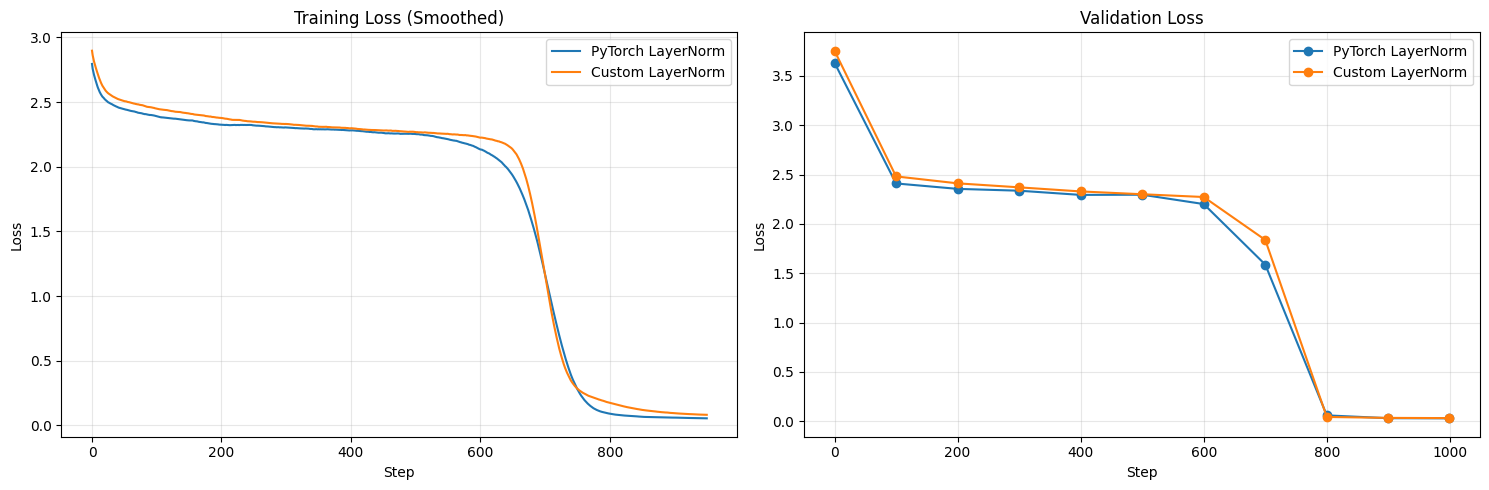

In [10]:
from matplotlib import pyplot as plt
import numpy as np
import os
plt.figure(figsize=(15, 5))


plt.subplot(1, 2, 1)
window = 50  
torch_smooth = np.convolve(torch_metrics['train_losses'], np.ones(window)/window, mode='valid')
custom_smooth = np.convolve(custom_metrics['train_losses'], np.ones(window)/window, mode='valid')

plt.plot(torch_smooth, label='PyTorch LayerNorm')
plt.plot(custom_smooth, label='Custom LayerNorm')
plt.title('Training Loss (Smoothed)')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(torch_metrics['val_steps'], torch_metrics['val_losses'], 'o-', label='PyTorch LayerNorm')
plt.plot(custom_metrics['val_steps'], custom_metrics['val_losses'], 'o-', label='Custom LayerNorm')
plt.title('Validation Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.3)

if not os.path.exists('plots'):
    os.makedirs('plots')
plt.tight_layout()
plt.savefig('plots/training_comparison.png', dpi=300)
plt.show()

In [11]:
def generate_text(model, prompt, max_len=100, temperature=0.8, top_k=40):
    model.eval()
    context = torch.tensor(encode(prompt), dtype=torch.long).unsqueeze(0).to(device)
    
    with torch.no_grad():
        generated = model.generate(
            context, 
            max_new_tokens=max_len,
            temperature=temperature, 
            top_k=top_k
        )
    
    model.train()
    return decode(generated[0].tolist())

prompts = ["O Romeo, Romeo", "To be or not", "Friends, Romans"]
temperatures = [0.8, 1.0, 0.7]
top_ks = [40, None, 20]

print("Text Generation Comparison:")
for prompt, temp, k in zip(prompts, temperatures, top_ks):
    print(f"\nPrompt: '{prompt}' (temp={temp}, top_k={k})")
    
    print("\nPyTorch LayerNorm:")
    print(generate_text(torch_model, prompt, temperature=temp, top_k=k)[:300])
    
    print("\nCustom LayerNorm:")
    print(generate_text(custom_model, prompt, temperature=temp, top_k=k)[:300])
    
    print("-" * 80)

Text Generation Comparison:

Prompt: 'O Romeo, Romeo' (temp=0.8, top_k=40)

PyTorch LayerNorm:
O Romeo, Romeoomeomomemmomemmmmommmmmmmmmmmmmmmmmmemmomememmmmeomommmemmomemememmmmmmmmmmmmmmmmmmmmmmmmmmemmmmmomm

Custom LayerNorm:
O Romeo, Romeommeemeeemomeemmememeeeeeeeemmeemeemeemememmmemommmemmmmememmmmmmeememmeeememememmememememememmmmemmm
--------------------------------------------------------------------------------

Prompt: 'To be or not' (temp=1.0, top_k=None)

PyTorch LayerNorm:
To be or notoronotnonottononnotonnnnnnnnnnnnnnnnnnotnnnonotnnnonnonnnottonononettnnnnnnnnnnnnnnnnntnnnnnnotonono

Custom LayerNorm:
To be or nottttttttttttbettttttttttttttttttttttttttttttttt tttttttttttttatttttttttttttttttttttttttnttttttttttt.t
--------------------------------------------------------------------------------

Prompt: 'Friends, Romans' (temp=0.7, top_k=20)

PyTorch LayerNorm:
Friends, Romans,isas, sasss,,,,ssasasaaaaaaaaaaaa,asas,a,isaasas,asasasas,a,a,,,aaaaaaaaaasaaasaaaasaasa:a,a,,aass

,Metric,PyTorch LayerNorm,Custom LayerNorm,Difference (%)
0,Training Time (s),99.82,104.69,4.88%
1,Steps per Second,10.02,9.55,-4.66%
2,Best Validation Loss,0.0285,0.0309,8.09%
3,Perplexity,1.03,1.03,0.23%
4,Steps to 90% Convergence,755,747,-1.06%
5,Loss Stability (std),0.005231,0.010027,91.67%
6,Memory Usage (MB),367.66,368.75,0.30%
7,Parameters,"7,197,761","7,197,761",0.00%
8,LN Output Mean Abs,0.7917,0.7916,-0.01%
9,LN Output Std,1.0103,1.0089,-0.13%


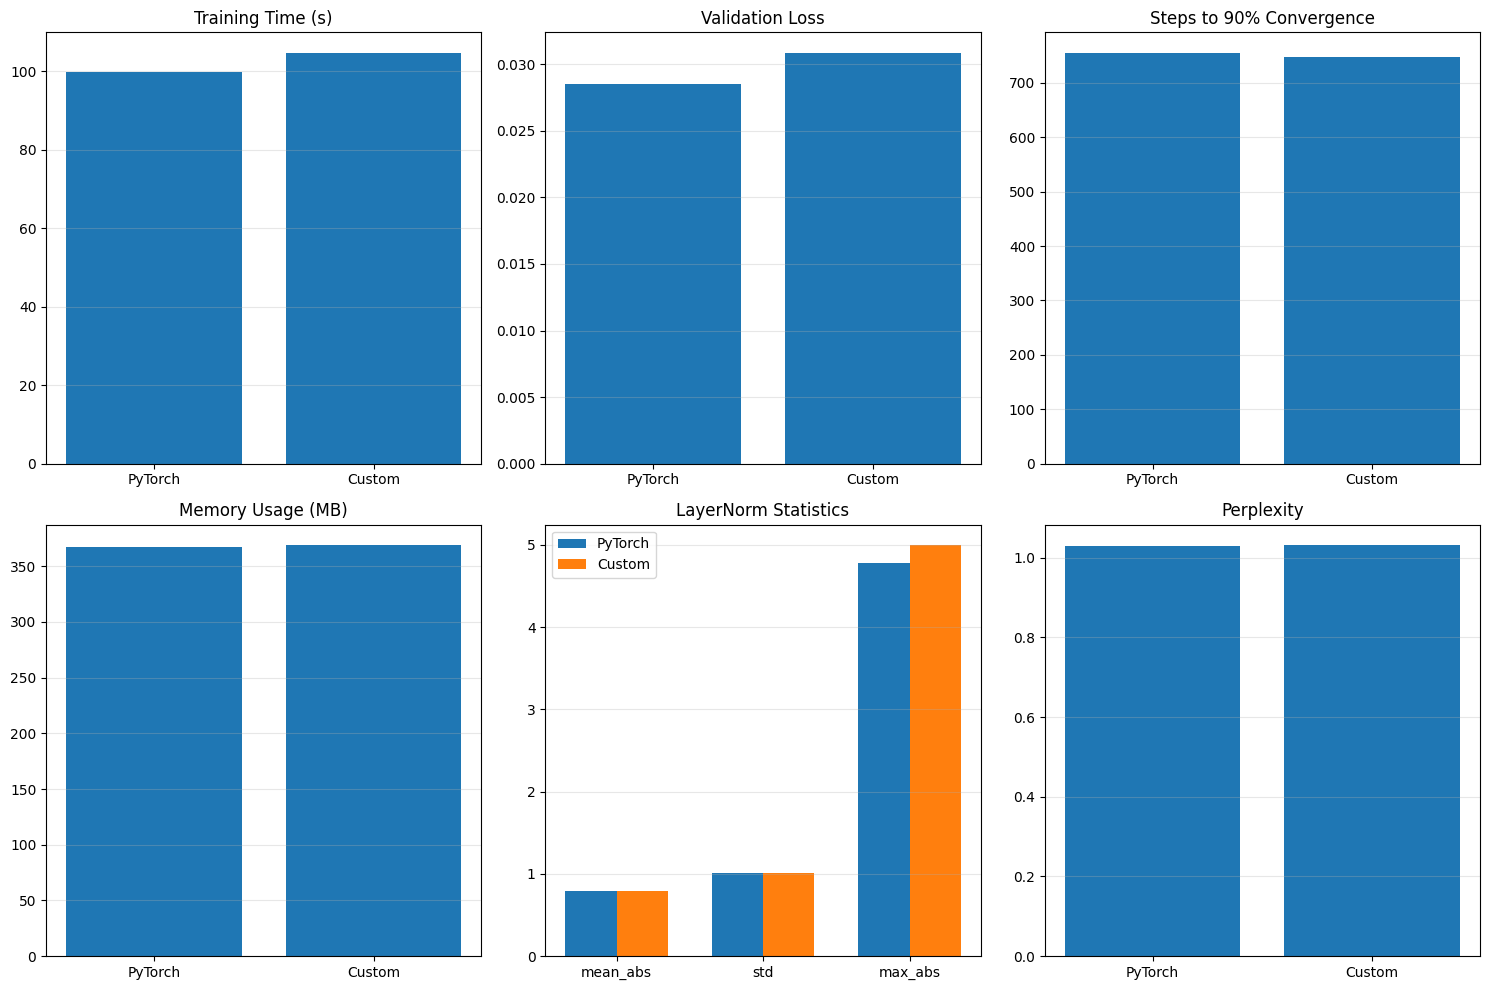

In [12]:
torch_time = torch_metrics['total_time']
custom_time = custom_metrics['total_time']

torch_val = torch_metrics['best_val_loss']
custom_val = custom_metrics['best_val_loss']

import pandas as pd

torch_steps_per_sec = max_steps / torch_time
custom_steps_per_sec = max_steps / custom_time

def steps_to_convergence(losses, target_improvement=0.9):
    initial_loss = losses[0]
    final_loss = losses[-1]
    target_loss = initial_loss - target_improvement * (initial_loss - final_loss)
    
    for step, loss in enumerate(losses):
        if loss <= target_loss:
            return step
    return len(losses)  

torch_convergence = steps_to_convergence(torch_metrics['train_losses'])
custom_convergence = steps_to_convergence(custom_metrics['train_losses'])

torch_loss_stability = np.std(torch_metrics['train_losses'][-100:])  # Last 100 steps
custom_loss_stability = np.std(custom_metrics['train_losses'][-100:])

import torch
with torch.no_grad():
    x, _ = get_batch('train')
    
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    _ = torch_model(x)
    torch_memory = torch.cuda.max_memory_allocated() / (1024**2)  # MB
    
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    _ = custom_model(x)
    custom_memory = torch.cuda.max_memory_allocated() / (1024**2)  # MB

torch_perplexity = np.exp(torch_val)
custom_perplexity = np.exp(custom_val)

torch_params = sum(p.numel() for p in torch_model.parameters())
custom_params = sum(p.numel() for p in custom_model.parameters())

def get_layernorm_stats(model):
    ln_outputs = []
    hooks = []
    
    for module in model.modules():
        if isinstance(module, (nn.LayerNorm, CustomLayerNorm)):
            def hook_fn(module, input, output, outputs=ln_outputs):
                outputs.append(output.detach())
            
            hooks.append(module.register_forward_hook(hook_fn))
    
    with torch.no_grad():
        x, _ = get_batch('val')
        _ = model(x)
    
    stats = {
        'mean_abs': 0,
        'std': 0,
        'max_abs': 0
    }
    
    if ln_outputs:
        for out in ln_outputs:
            stats['mean_abs'] += torch.mean(torch.abs(out)).item()
            stats['std'] += torch.std(out).item()
            stats['max_abs'] += torch.max(torch.abs(out)).item()
        
        for k in stats:
            stats[k] /= len(ln_outputs)
    
    for hook in hooks:
        hook.remove()
        
    return stats

torch_ln_stats = get_layernorm_stats(torch_model)
custom_ln_stats = get_layernorm_stats(custom_model)

comparison = pd.DataFrame({
    'Metric': [
        'Training Time (s)', 
        'Steps per Second',
        'Best Validation Loss',
        'Perplexity',
        'Steps to 90% Convergence',
        'Loss Stability (std)',
        'Memory Usage (MB)',
        'Parameters',
        'LN Output Mean Abs',
        'LN Output Std',
        'LN Output Max Abs'
    ],
    'PyTorch LayerNorm': [
        f"{torch_time:.2f}",
        f"{torch_steps_per_sec:.2f}",
        f"{torch_val:.4f}",
        f"{torch_perplexity:.2f}",
        f"{torch_convergence}",
        f"{torch_loss_stability:.6f}",
        f"{torch_memory:.2f}",
        f"{torch_params:,}",
        f"{torch_ln_stats['mean_abs']:.4f}",
        f"{torch_ln_stats['std']:.4f}",
        f"{torch_ln_stats['max_abs']:.4f}"
    ],
    'Custom LayerNorm': [
        f"{custom_time:.2f}",
        f"{custom_steps_per_sec:.2f}",
        f"{custom_val:.4f}",
        f"{custom_perplexity:.2f}",
        f"{custom_convergence}",
        f"{custom_loss_stability:.6f}",
        f"{custom_memory:.2f}",
        f"{custom_params:,}",
        f"{custom_ln_stats['mean_abs']:.4f}",
        f"{custom_ln_stats['std']:.4f}",
        f"{custom_ln_stats['max_abs']:.4f}"
    ],
    'Difference (%)': [
        f"{(custom_time - torch_time) / torch_time * 100:.2f}%",
        f"{(custom_steps_per_sec - torch_steps_per_sec) / torch_steps_per_sec * 100:.2f}%",
        f"{(custom_val - torch_val) / torch_val * 100:.2f}%",
        f"{(custom_perplexity - torch_perplexity) / torch_perplexity * 100:.2f}%",
        f"{(custom_convergence - torch_convergence) / max(1, torch_convergence) * 100:.2f}%",
        f"{(custom_loss_stability - torch_loss_stability) / torch_loss_stability * 100:.2f}%",
        f"{(custom_memory - torch_memory) / torch_memory * 100:.2f}%",
        f"{(custom_params - torch_params) / torch_params * 100:.2f}%",
        f"{(custom_ln_stats['mean_abs'] - torch_ln_stats['mean_abs']) / torch_ln_stats['mean_abs'] * 100:.2f}%",
        f"{(custom_ln_stats['std'] - torch_ln_stats['std']) / torch_ln_stats['std'] * 100:.2f}%",
        f"{(custom_ln_stats['max_abs'] - torch_ln_stats['max_abs']) / torch_ln_stats['max_abs'] * 100:.2f}%"
    ]
})

display(comparison)

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.bar(['PyTorch', 'Custom'], [torch_time, custom_time])
plt.title('Training Time (s)')
plt.grid(axis='y', alpha=0.3)

plt.subplot(2, 3, 2)
plt.bar(['PyTorch', 'Custom'], [torch_val, custom_val])
plt.title('Validation Loss')
plt.grid(axis='y', alpha=0.3)

plt.subplot(2, 3, 3)
plt.bar(['PyTorch', 'Custom'], [torch_convergence, custom_convergence])
plt.title('Steps to 90% Convergence')
plt.grid(axis='y', alpha=0.3)

plt.subplot(2, 3, 4)
plt.bar(['PyTorch', 'Custom'], [torch_memory, custom_memory])
plt.title('Memory Usage (MB)')
plt.grid(axis='y', alpha=0.3)

plt.subplot(2, 3, 5)
metrics = ['mean_abs', 'std', 'max_abs']
torch_values = [torch_ln_stats[m] for m in metrics]
custom_values = [custom_ln_stats[m] for m in metrics]
x = np.arange(len(metrics))
width = 0.35
plt.bar(x - width/2, torch_values, width, label='PyTorch')
plt.bar(x + width/2, custom_values, width, label='Custom')
plt.xticks(x, metrics)
plt.title('LayerNorm Statistics')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.subplot(2, 3, 6)
plt.bar(['PyTorch', 'Custom'], [torch_perplexity, custom_perplexity])
plt.title('Perplexity')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('plots/metrics_comparison.png', dpi=300)
plt.show()




In [15]:
models_dir = 'models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

torch_model_path = os.path.join(models_dir, 'torch_model.pth')
custom_model_path = os.path.join(models_dir, 'custom_model.pth')

torch.save(torch_model.state_dict(), torch_model_path)
custom_model_cpu = custom_model.to('cpu')
torch.save(custom_model_cpu.state_dict(), custom_model_path)
custom_model = custom_model.to(device)

print(f"Models successfully saved to:")
print(f"- PyTorch model: {torch_model_path}")
print(f"- Custom model: {custom_model_path}")

Models successfully saved to:
- PyTorch model: models/torch_model.pth
- Custom model: models/custom_model.pth
